In [29]:
try:
    import skfda 
    # Il y avait une autre implémentation plus simple à utiliser ici https://fuzzy-c-means.readthedocs.io/en/latest/examples/00%20-%20Basic%20clustering/
    # Y'aurait pas eu besoin des FDataGrid chelou dommaJ
except ImportError:
    %pip install -q scikit-fda
    pass
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from utils import generate_blobs, generate_elongated, generate_outliers, experim, plot_data_with_label, plot_3D

## Question 1 : $c$-moyennes floues et possibilistes
### $c$-moyennes floues

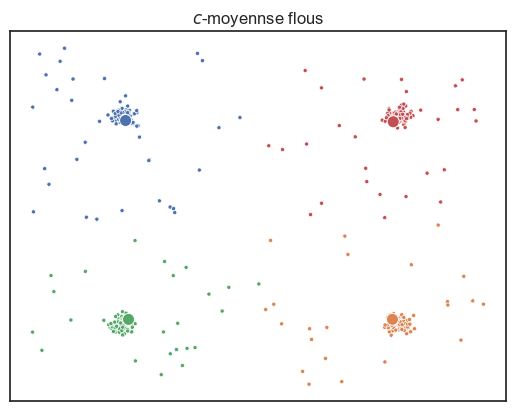

In [134]:
import pandas as pd

class FuzzyCMeans:
    def __init__(self, n_clusters=2, max_iter=200, m=2):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.centroids_ = None
        self.membership_weights_ = None

    def fit(self, df):
        # Initialize variables
        n, d = df.shape
        self.membership_weights_ = self._initializeMembershipWeights(n, self.n_clusters)

        for _ in range(self.max_iter):
            self.centroids_ = self._computeCentroids(df, self.membership_weights_, d)
            self.membership_weights_ = self._updateWeights(df, self.membership_weights_, self.centroids_)

    def predict(self, df):
        return self.predict_proba(df).argmax(axis=1)
    
    def predict_proba(self, df):
        # Check if the model is fitted
        if self.centroids_ is None:
            raise Exception("Model is not fitted yet.")
        
        # Initialize variables
        n, d = df.shape
        membership_weights_ = self._initializeMembershipWeights(n, self.n_clusters)
        
        return self._updateWeights(df, membership_weights_, self.centroids_)

    def _initializeMembershipWeights(self, n, k):
        weight = np.random.dirichlet(np.ones(k), n)
        return np.array(weight)

    def _computeCentroids(self, df, weight_arr, d):
        C = []
        for i in range(self.n_clusters):
            weight_sum = np.power(weight_arr[:, i], self.m).sum()
            Cj = [(df.iloc[:, x].values * np.power(weight_arr[:, i], self.m)).sum() / weight_sum for x in range(d)]
            C.append(Cj)
        return np.array(C)

    def _updateWeights(self, df, weight_arr, C):
        n = df.shape[0]
        denom = np.zeros(n)
        for i in range(self.n_clusters):
            dist = np.sqrt(((df - C[i]) ** 2).sum(axis=1))
            denom += np.power(1 / dist, 1 / (self.m - 1))

        for i in range(self.n_clusters):
            dist = np.sqrt(((df - C[i]) ** 2).sum(axis=1))
            weight_arr[:, i] = np.power(1 / dist, 1 / (self.m - 1)) / denom
        return weight_arr

centers = [(-20, -20), (-20, 20), (20, -20), (20, 20)]
cov = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]
n_clusters = len(centers)
X_train, X_outliers = generate_elongated(
    n_samples=300, n_clusters=n_clusters, centers=centers, cov=cov, n_outliers=100
)
X = np.concatenate((X_train, X_outliers))
df = pd.DataFrame(X) # Some DataFrame
fm = FuzzyCMeans(n_clusters=n_clusters, max_iter=200, m=2)
fm.fit(df)
plot_data_with_label(
    X,
    labels_true=fm.membership_weights_.argmax(axis=1),
    cluster_centers=fm.centroids_,
    title='$c$-moyennse flous',
    legend=False
)


### $c$-moyennes possibilistes

array([[-18.38065236,   8.86539538],
       [-18.38065236,   8.86539538],
       [ 16.88038889,  -7.50443874],
       [ 16.88038889,  -7.50443874]])

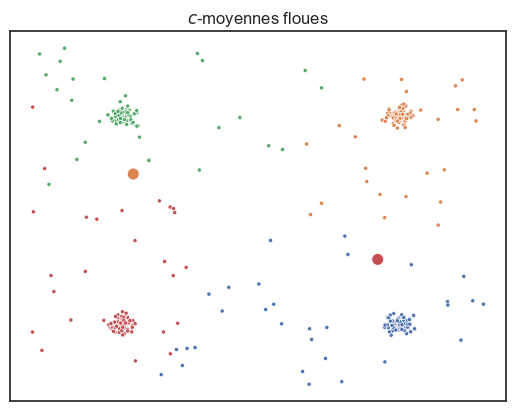

In [136]:
class PossibilisticCMeans(FuzzyCMeans):
    def __init__(self, n_clusters=2, max_iter=200, m=2, eta=None):
        super().__init__(n_clusters, max_iter, m)
        if not eta:
            eta = np.ones((n_clusters,)) - 0.5
        self.eta = eta
    
    def _updateWeights(self, df, weight_arr, C):
        X = df.values
        for i in range(self.n_clusters):
            dist = np.linalg.norm(X - C[i], axis=1)
            weight_arr[:, i] = 1 + np.power( dist / self.eta[i] , 2 / (self.m - 1))
        return weight_arr
df = pd.DataFrame(X) # Some DataFrame
p_cmeans = PossibilisticCMeans(n_clusters=n_clusters, max_iter=500, m=2)
p_cmeans.fit(df)
plot_data_with_label(
    X,
    labels_true=p_cmeans.membership_weights_.argmax(axis=1),
    cluster_centers=p_cmeans.centroids_,
    title='$c$-moyennes floues',
    legend=False
)
p_cmeans.centroids_

On voit que certain cluster fusionnent suite au relachement de la contrainte de sur le degré d'appartenance.

## Question 2 : Comparaison des algorithmes sur des données gaussiens


TODO:

- Compute accuracy in each figs
- $c$-moyennes possibilistes


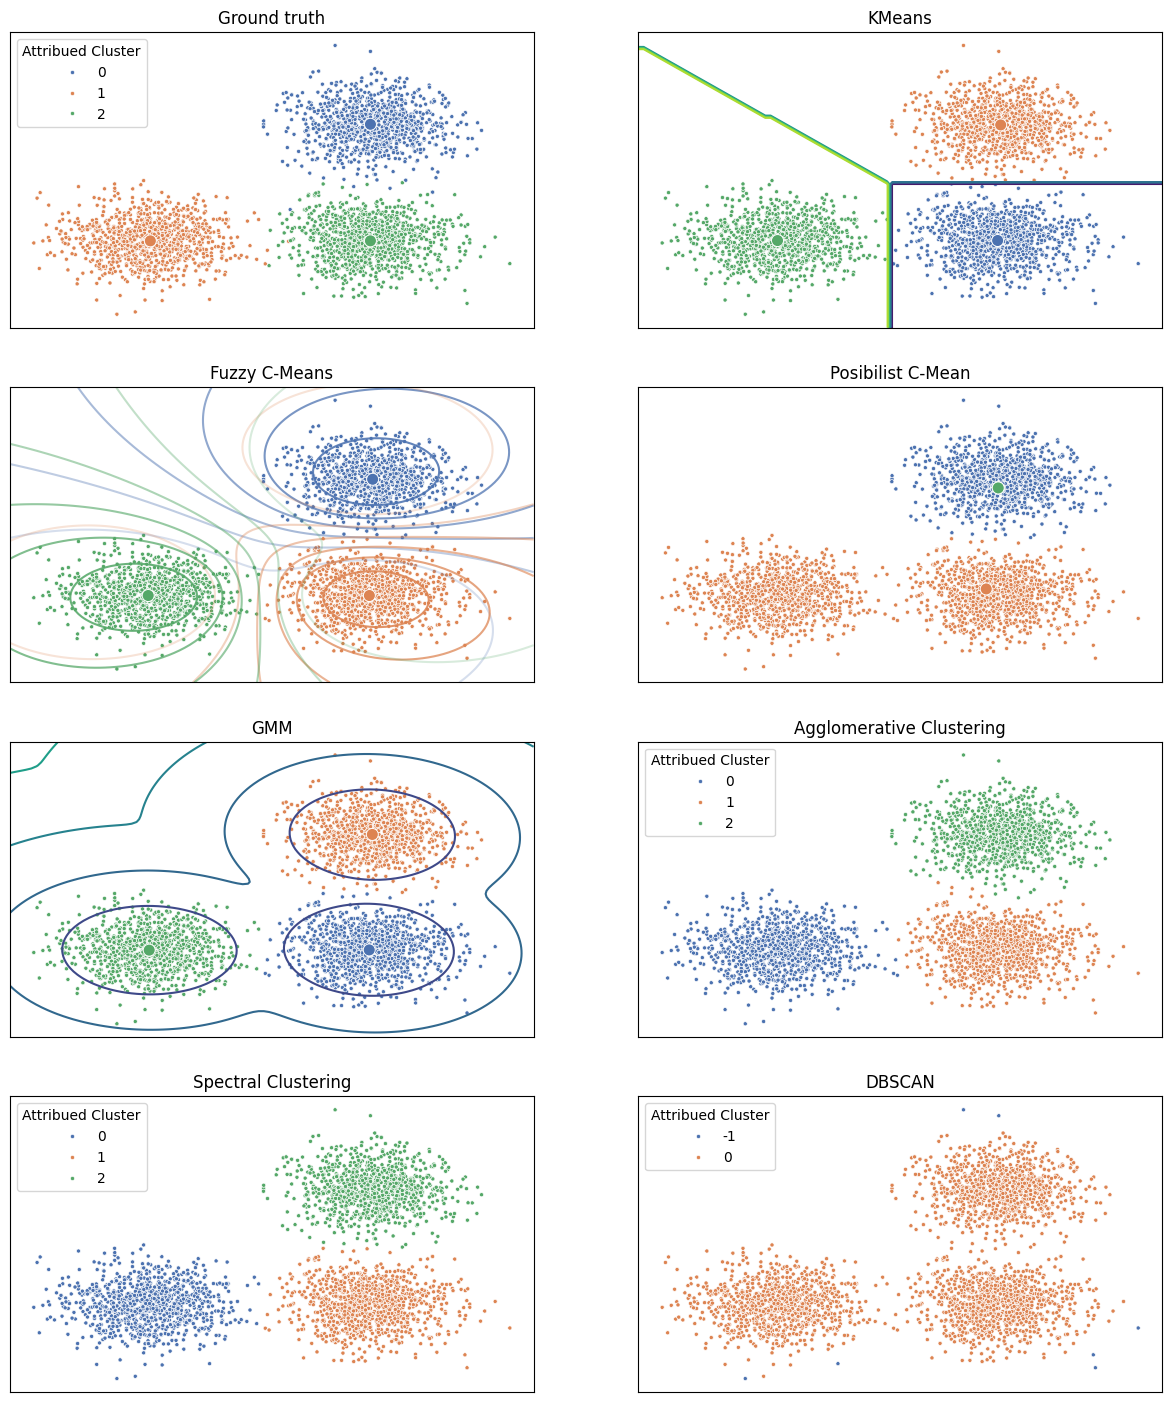

In [35]:
centers = np.array([[2, 2], [-2, -2], [2, -2]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, labels_true, centers)

Dans ce première exemple, on peut voir que, excepté DBSCAN, nos algorithmes arrivent à partionner notre jeu de données.

Dans le cas de DBSCAN, il est surement nécessaire de paufiner son hyperparamètre principal : $\varepsilon$.

Les lignes de niveau de l'algorithme c-moyenne flou sont interéssantes, regardons les de plus près.

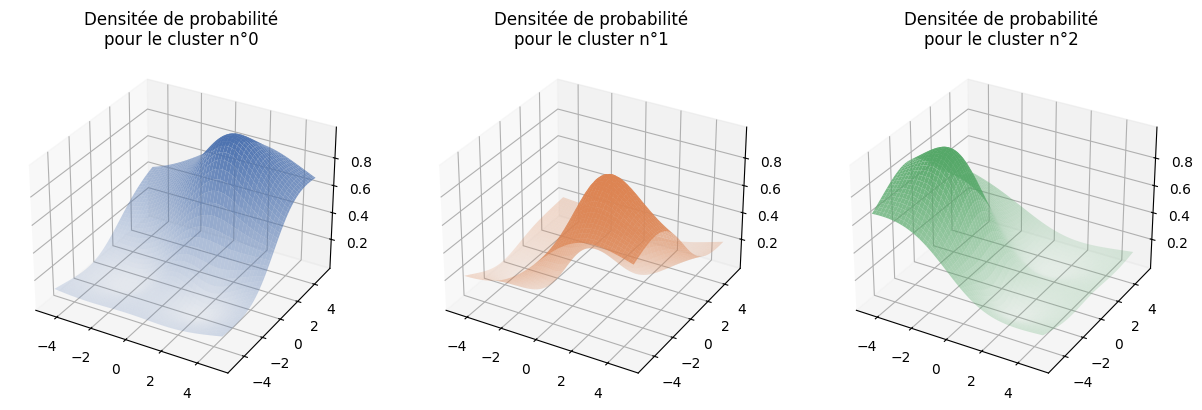

In [36]:
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

On peut voir que la densité d'appartenance à un cluster forme deux creux tombant à zéro au locus des deux autres clusters, c'est particulièrement visible sur le graphique bleu ici. L'algorithme des $c$-moyennes floues prend en compte la position des autres clusters.


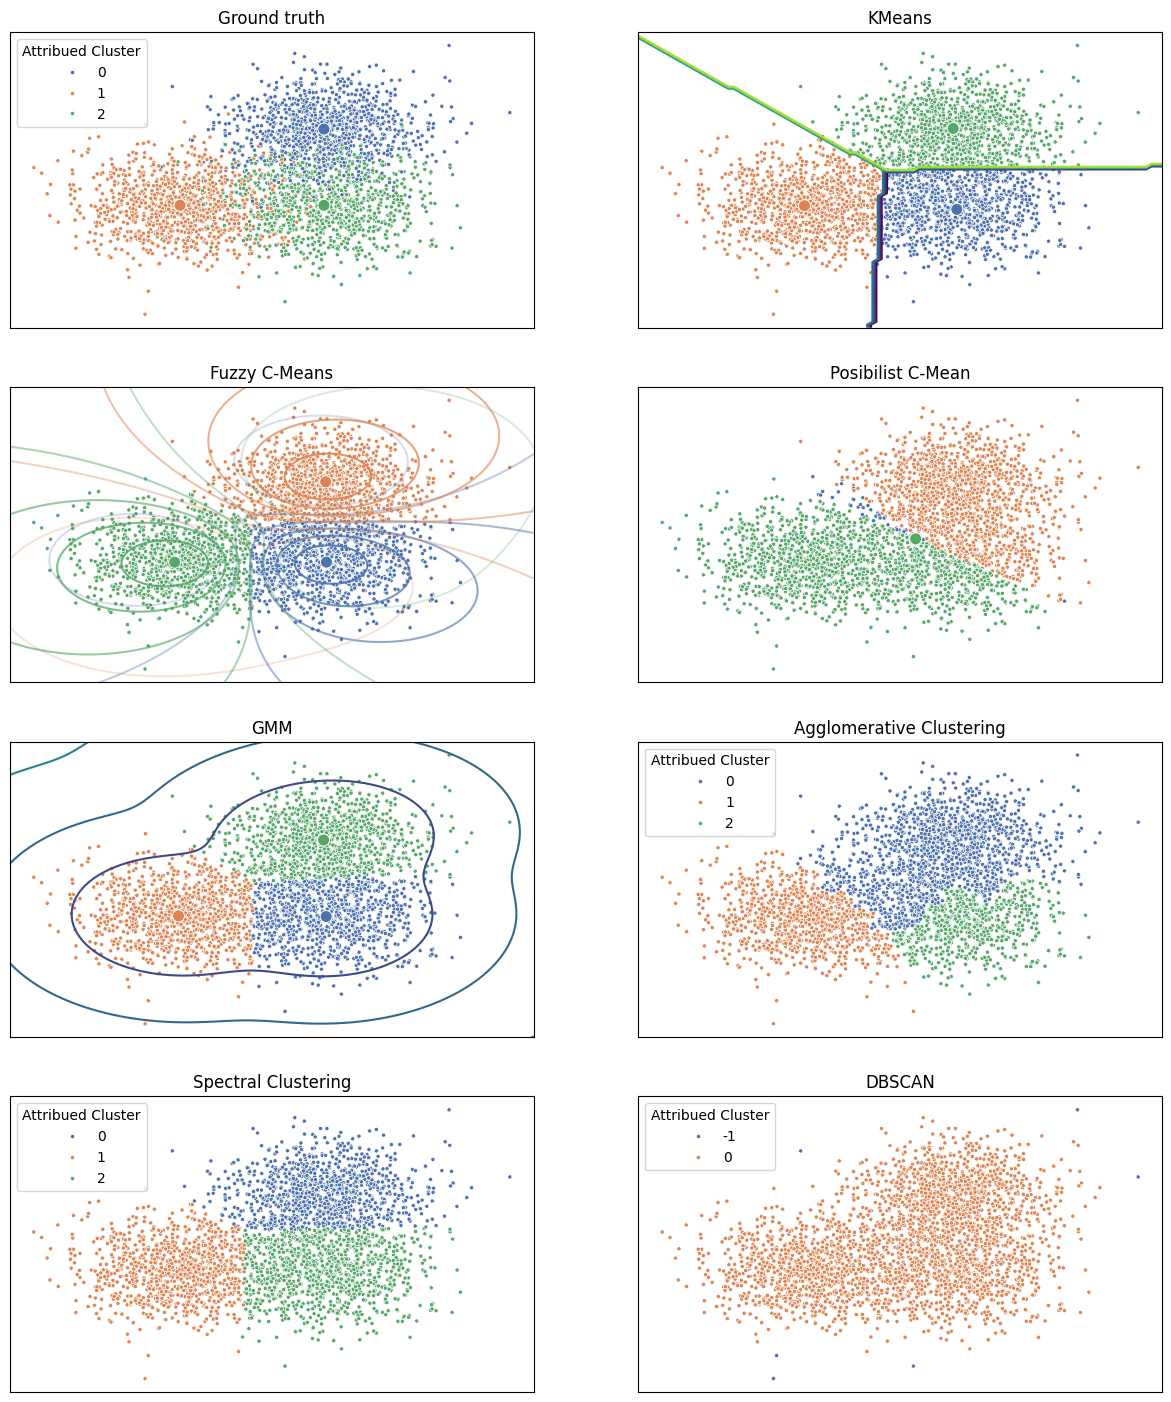

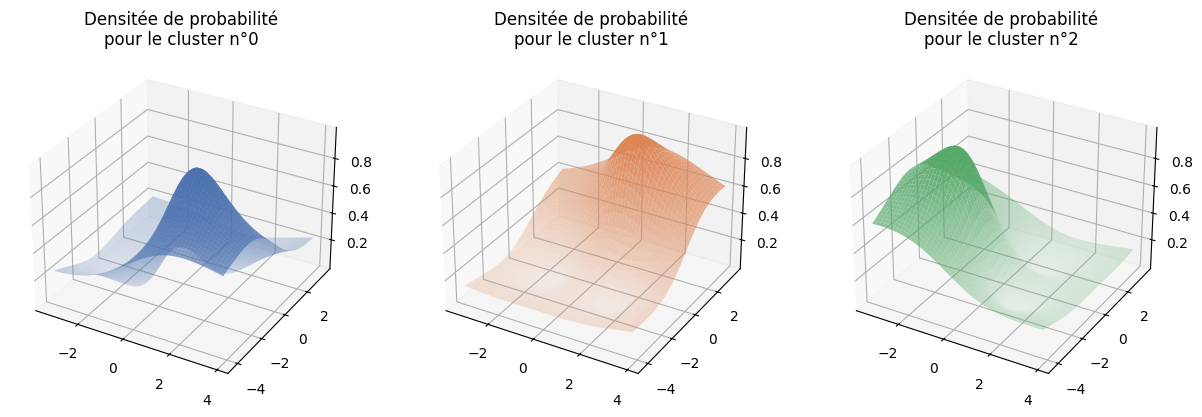

In [37]:
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, labels_true, centers)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

On retrouve le même genre de densité pour les $c$-moyennes floues que précédement tandis que les résultats du clustering agglomératif sont plus variables.


## Question 3 : Comparaison des résultats sur les données `halfmoon`


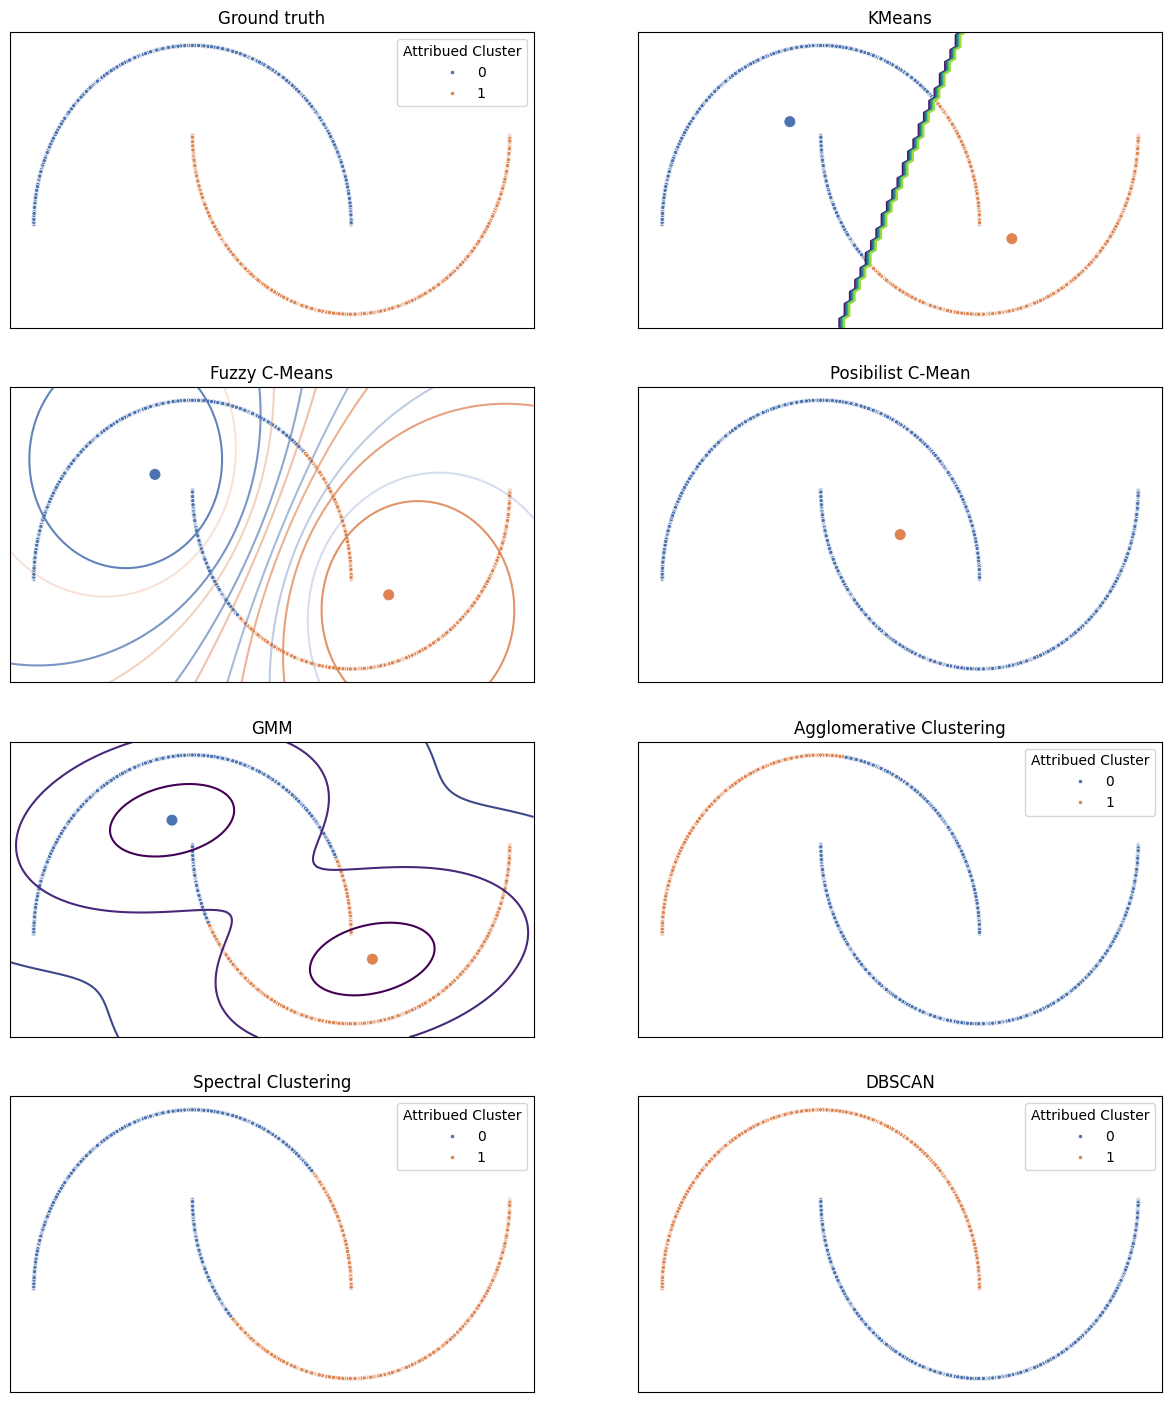

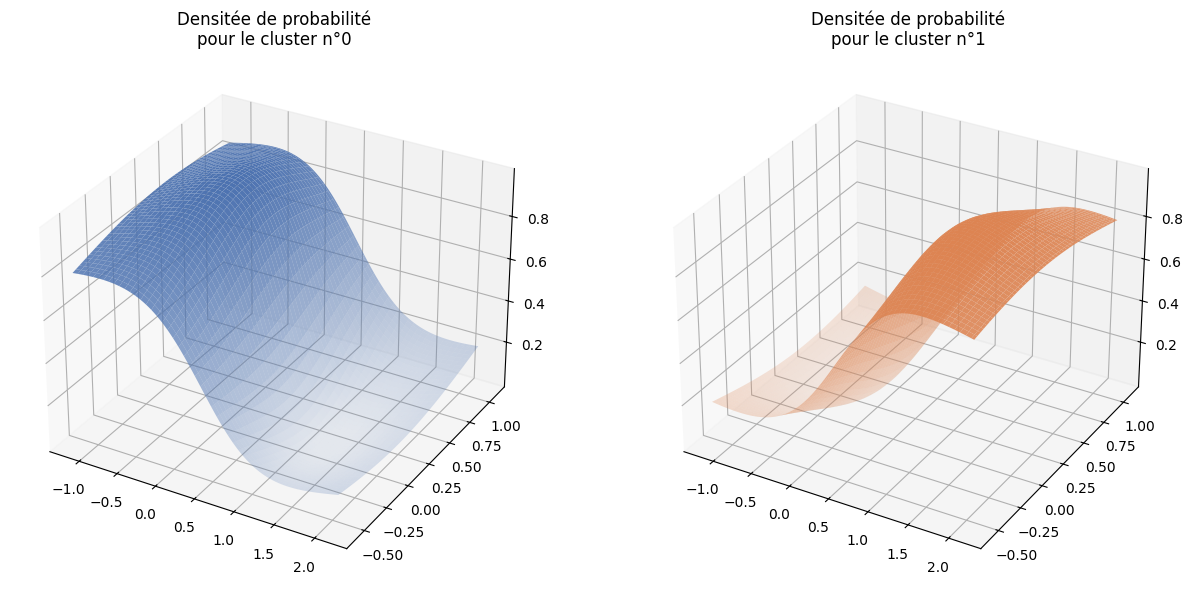

In [38]:
X, labels_true = make_moons(n_samples=3000)
estimators, XX, X_mesh, Y_mesh = experim(X, 2, labels_true)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], 2)

## Question 4 : Tolérance aux outliers


In [39]:
centers = [(-20, -20), (-20, 20), (20, -20), (20, 20)]
cov = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]
n_clusters = len(centers)
X_train, X_outliers = generate_elongated(
    n_samples=300, n_clusters=n_clusters, centers=centers, cov=cov
)
obs = np.array([[0, 0]])  # le centre du plan 2D

### Sans outliers : baseline


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


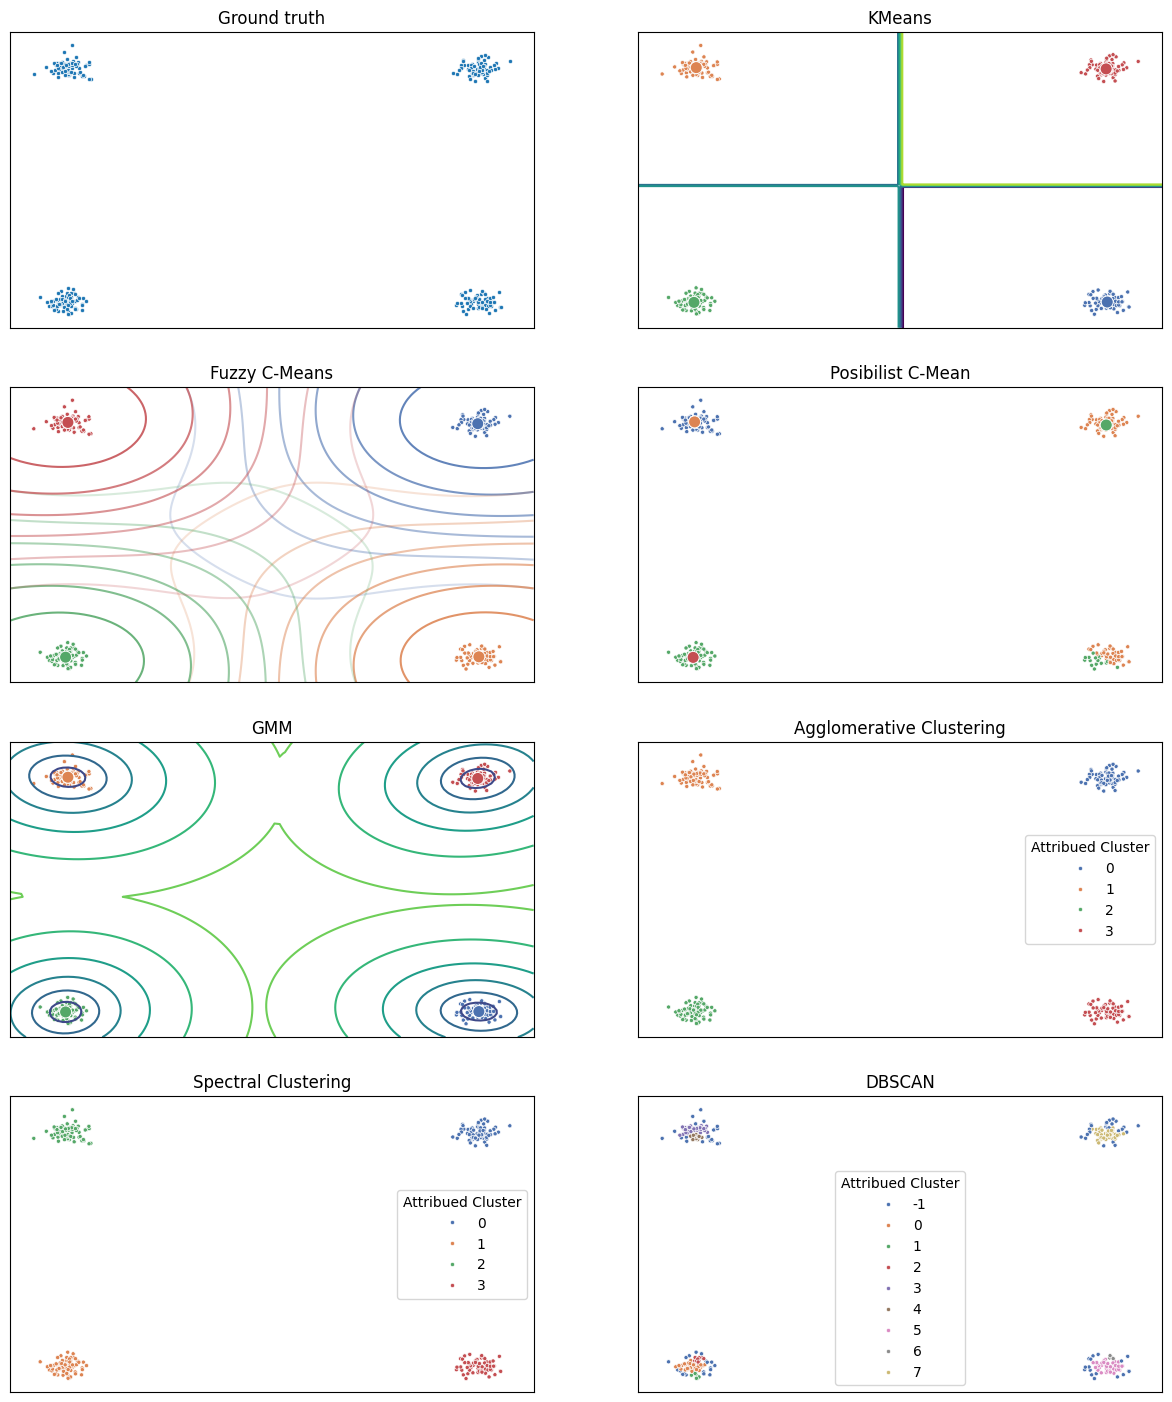

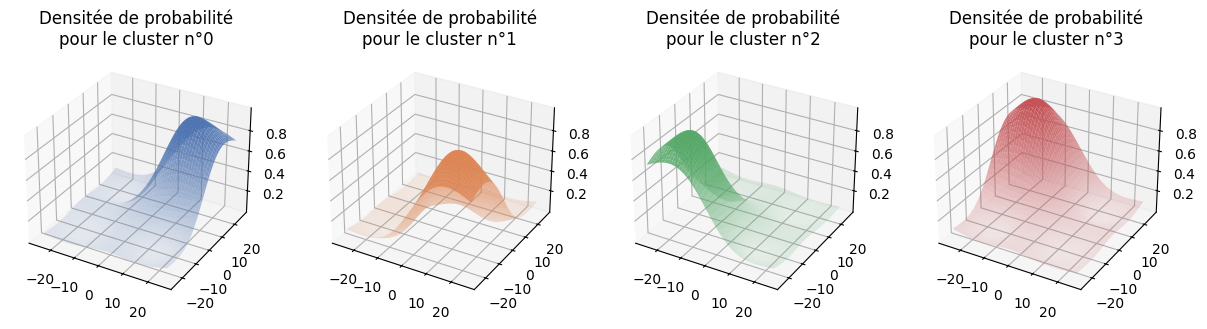

In [40]:
estimators, XX, X_mesh, Y_mesh = experim(X_train, n_clusters)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

Aucun problème avant l'introduction d'outliers. Belle symétrie des densités, que cela soit pour les $c$-moyennes floues, les $c$-moyennes possibilistes ou les GMM.


### Introduction d'outliers


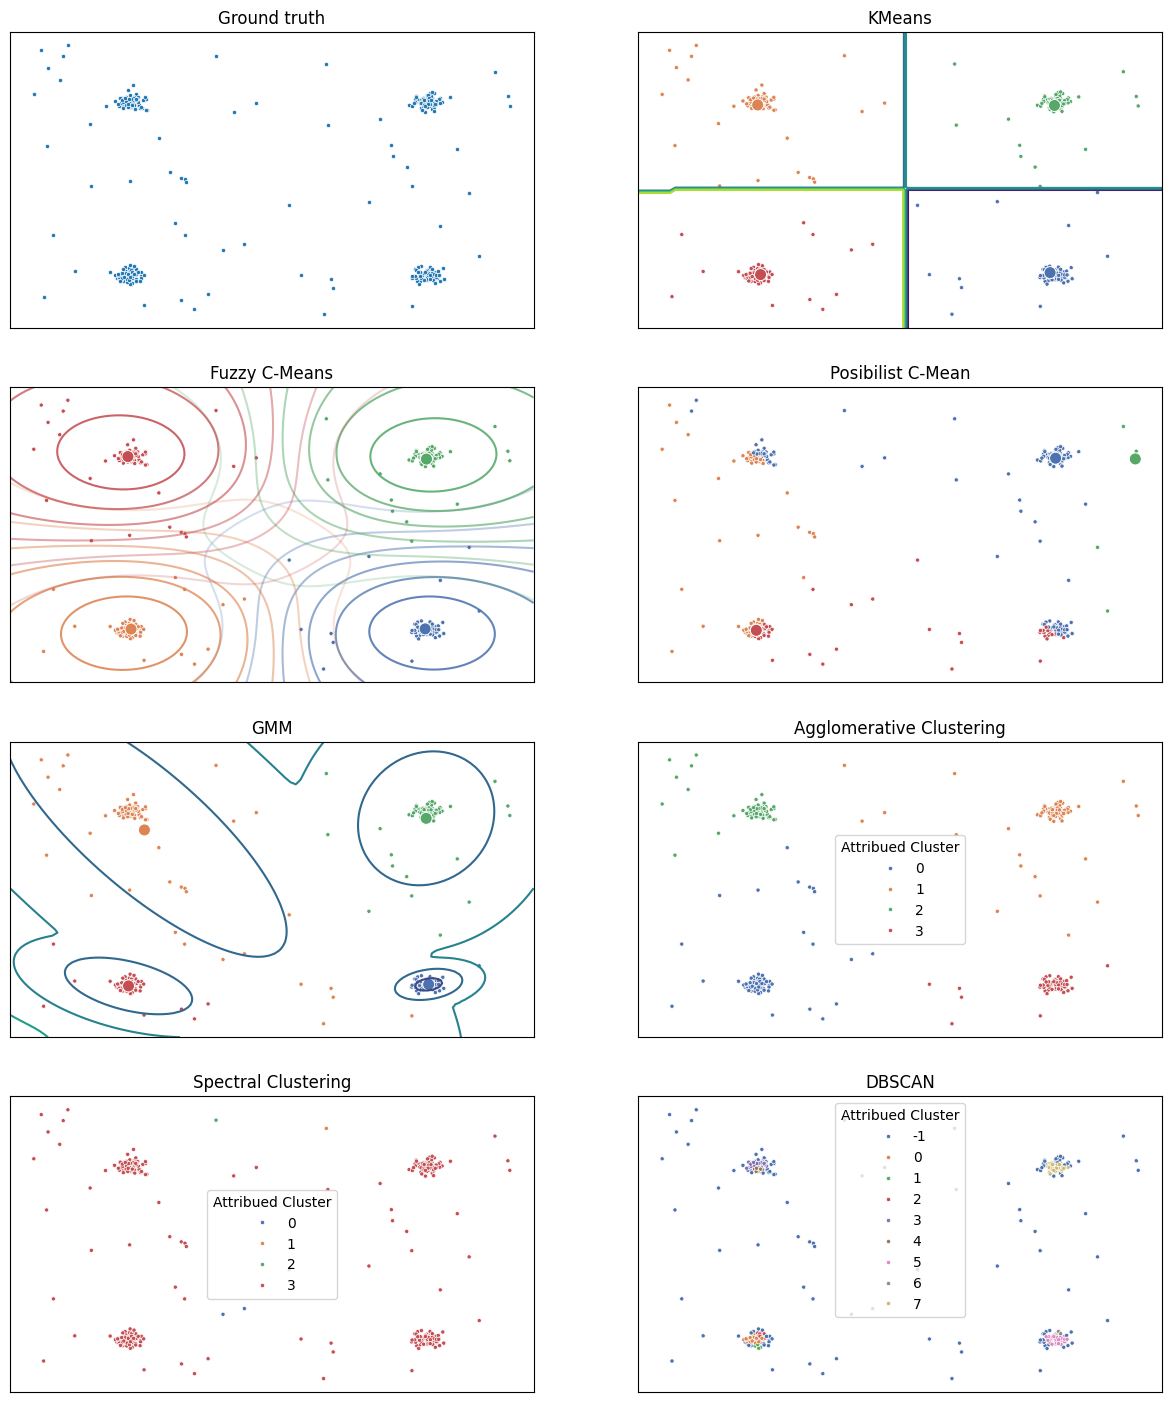

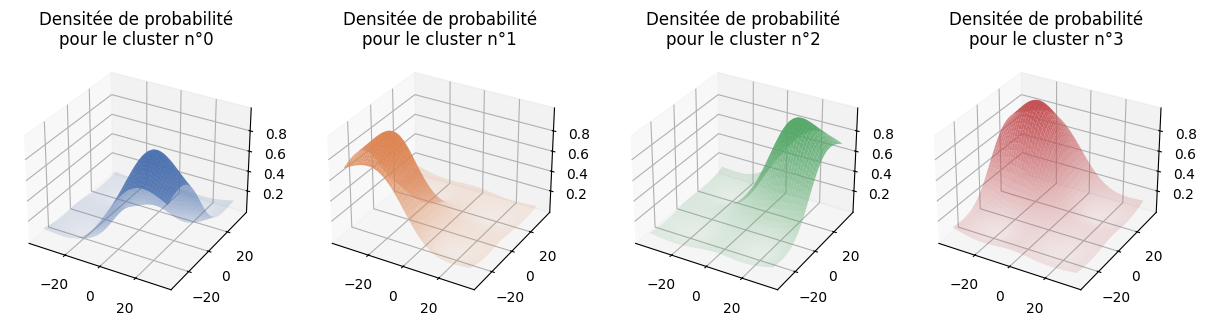

In [41]:
estimators, XX, X_mesh, Y_mesh = experim(
    np.concatenate((X_train, X_outliers), 0), n_clusters
)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

- On peut voir que les $c$-moyennes floues et les $k$-moyennes ont une belle résilience aux outliers ;
- Le clustering agglomératif s'en sort bien également mais avec des frontières plus floues comparées à celles des $k$/$c$-moyennes ;
- GMM, DBSCAN et le spectral clustering ont de réels difficultés à équilibrer le plan 2D, ne trouvant parfois pas le bon nombre de clusters.


### Pertubation avec une exception ambiguë à tous les clusters


Passons sur uniquement deux clusters :


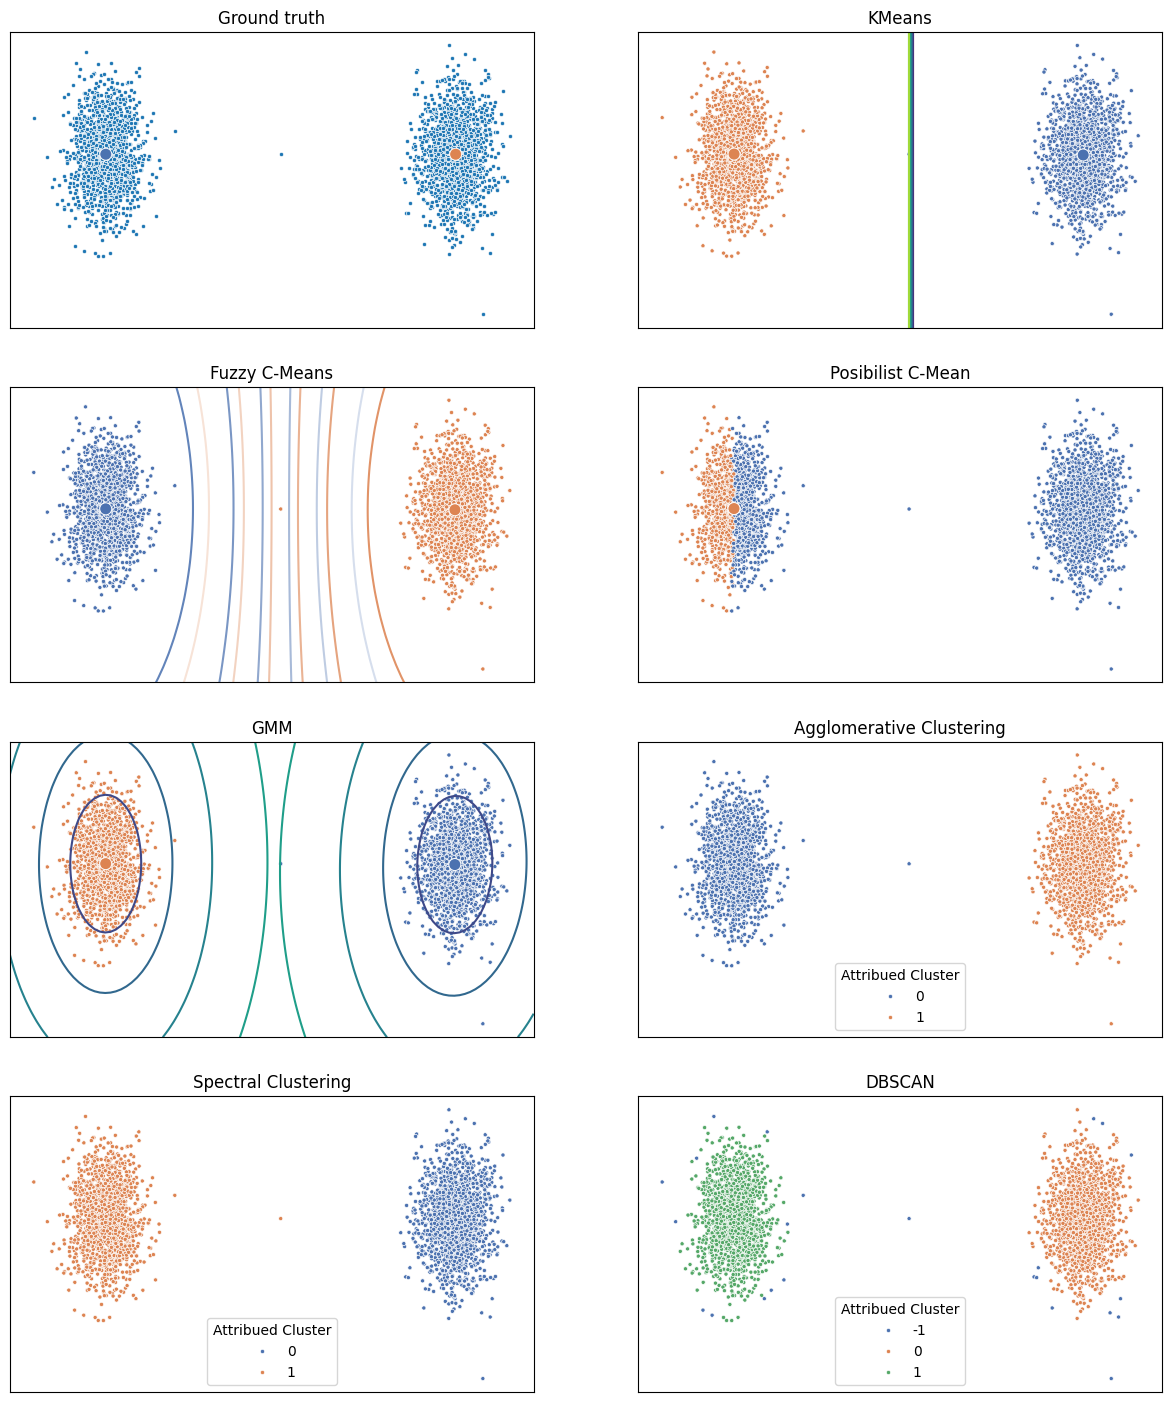

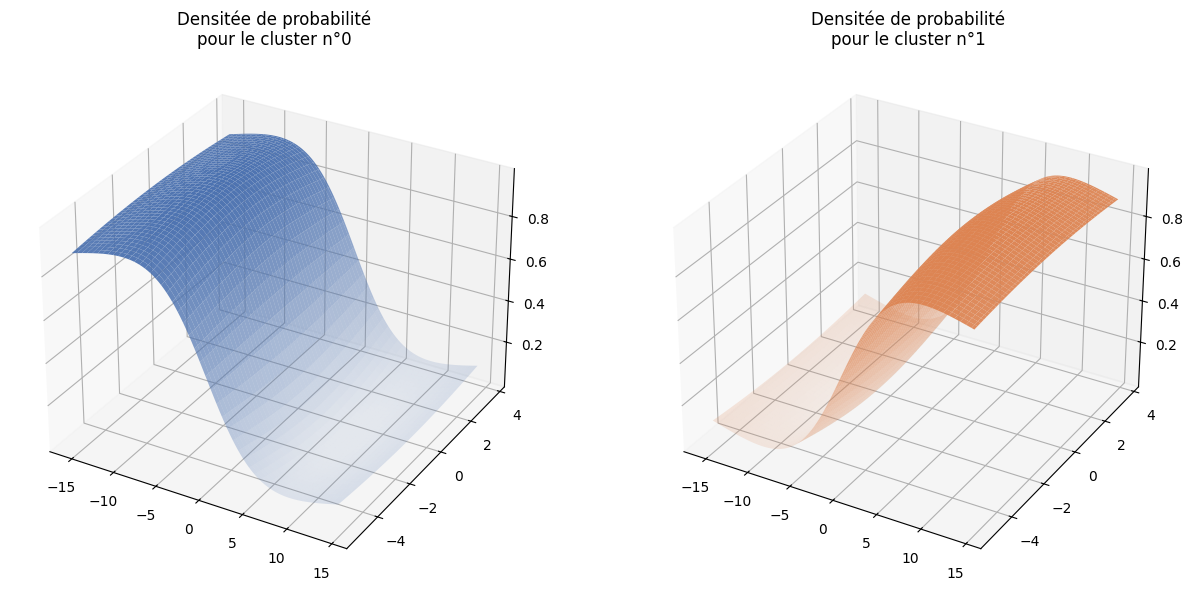

In [42]:
obs = np.array([[0, 0]])  # le centre du plan 2D
centers = np.array([[-10, 0], [10, 0]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=1)
X = np.concatenate((X, obs), 0)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, centers=centers)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

La plupart des algorithmes testés performent une classification binaire. Néanmoins, on peut regarder les probabilités et degrés d'appartenance aux clusters pour les algorithmes suivants :


In [43]:
from IPython.display import HTML

fuzzy_prob_obs = (
    estimators["fuzzy_cmeans"].predict_proba(skfda.FDataGrid(obs, [0, 1])).squeeze()
)
gmm_prob_obs = estimators["gmm"].predict_proba(obs).squeeze()
display(
    HTML(
        f"""
    <table>
    <tr>
        <td>Degré d&#39;appartenance</td>
        <td>Cluster 1</td>
        <td>Cluster 2</td>
    </tr>
    <tr>
        <td>c-moyenne floue</td>
        <td>{fuzzy_prob_obs[0]}</td>
        <td>{fuzzy_prob_obs[1]}</td>
    </tr>
    <tr>
        <td>GMM</td>
        <td>{gmm_prob_obs[0]:.2f}</td>
        <td>{gmm_prob_obs[1]:.2f}</td>
    </tr>
</table>
    """
    )
)

C'est dans ce genre de cas que l'on voit que les $c$-moyennes floues n'indiquent pas une probabilité. En effet, la motivation à l'origine des $c$-moyennes floues était de pouvoir traiter les cas ambigus en permetant un chevauchement des clusters. Pour cette algorithme, le point appartient à part égale au deux clusters.

Pour le GMM, on voit que le point n'appartient pas à part égal aux deux clusters : l'algorithme fait un choix pour la classification de ce point ambigu.


## Question 5 : Stabilité


100%|██████████| 3000/3000 [01:03<00:00, 47.23it/s]


<Axes: title={'center': 'Distribution de la précision\npour $c$-moyennes floues'}, xlabel='Accuracy', ylabel='Count'>

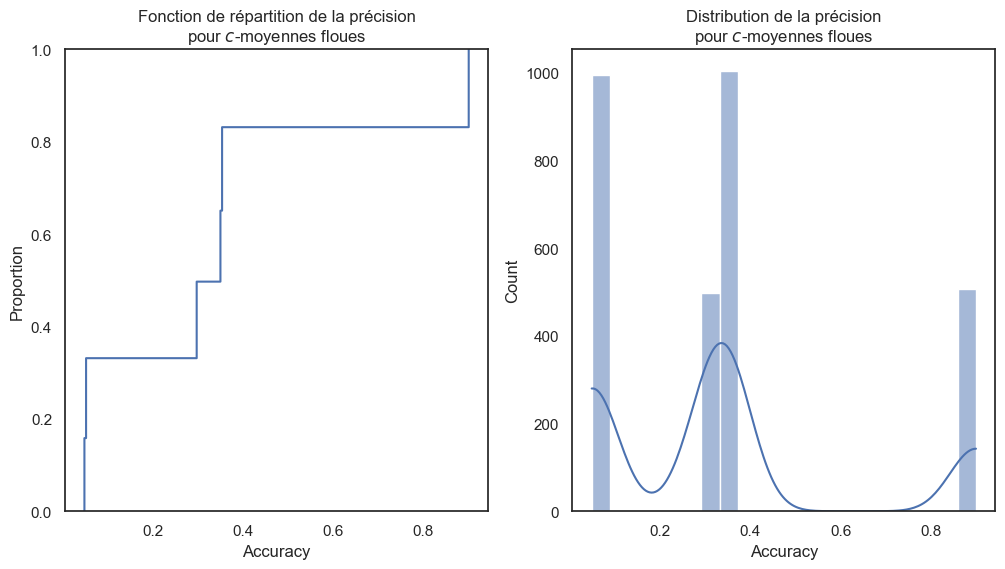

In [114]:
from tqdm import tqdm
import seaborn as sns
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    fuzzy_cmeans = skfda.ml.clustering.FuzzyCMeans(
        n_clusters=n_clusters, n_init=1, random_state=np.random.randint(0, 100000)
    )
    fuzzy_cmeans.fit(fd)
    yhat = fuzzy_cmeans.predict(fd)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $c$-moyennes floues")
ax2.set_title("Distribution de la précision\npour $c$-moyennes floues")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

100%|██████████| 3000/3000 [00:16<00:00, 187.32it/s]


<Axes: title={'center': 'Distribution de la précision\npour $k$-moyenne'}, xlabel='Accuracy', ylabel='Count'>

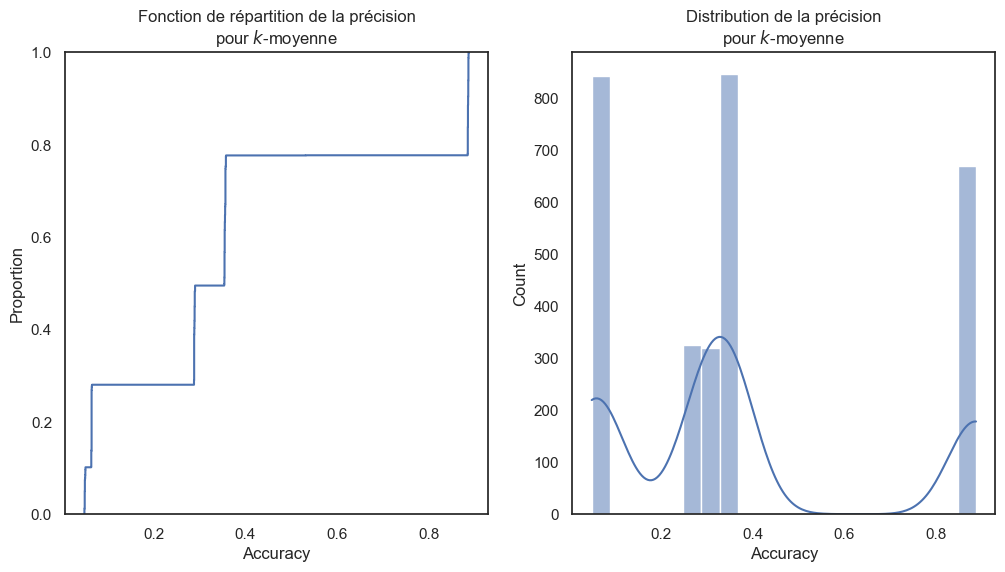

In [113]:
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    k_means = KMeans(n_clusters=n_clusters, n_init=1, random_state=np.random.randint(0, 100000)).fit(X)
    yhat = k_means.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $k$-moyenne")
ax2.set_title("Distribution de la précision\npour $k$-moyenne")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

En veillant à fixer le paramètre `n_init`, on observe une grande variance dans les performances du $c$-moyennes floues, héritant cette propriété de sa version non floue. 

Testons d'autres initialisation des centres.

100%|██████████| 500/500 [10:05<00:00,  1.21s/it]


<Axes: title={'center': 'Distribution de la précision\npour $c$-moyennes floues'}, xlabel='Accuracy', ylabel='Count'>

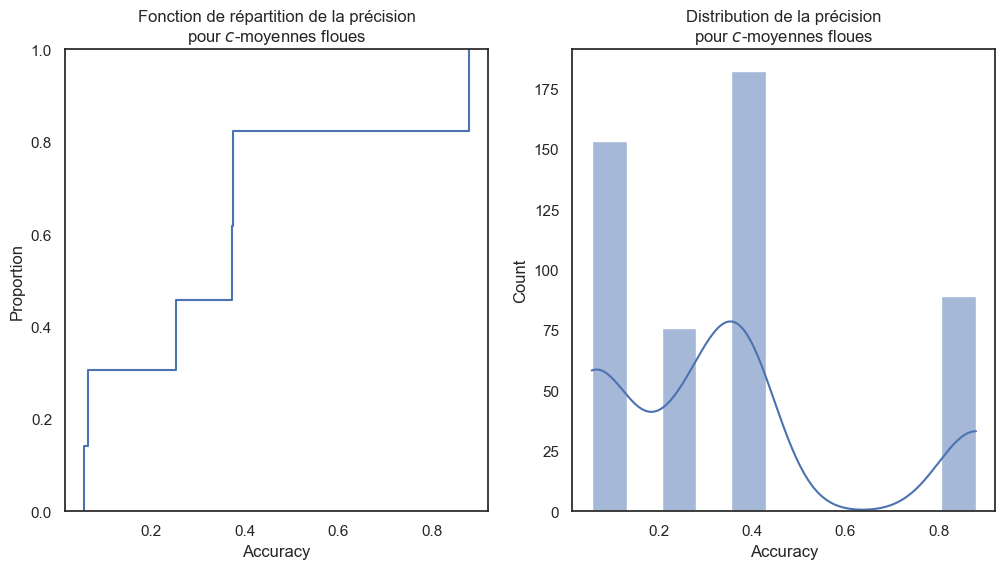

In [118]:
from tqdm import tqdm
import seaborn as sns
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=0.7)
X = pd.DataFrame(X)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(500)):
    fuzzy_cmeans = FuzzyCMeans(n_clusters=n_clusters)
    fuzzy_cmeans.fit(X)
    yhat = fuzzy_cmeans.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $c$-moyennes floues")
ax2.set_title("Distribution de la précision\npour $c$-moyennes floues")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

Notre implémentation du $c$-moyennes floues au début de ce notebook utilisait une initialisation des poids impliquant une distribution de Dirichlet. Visiblement celà n'aide pas à réduire la variance dans les résultats.

Testons une l'initialisation "k-means++" de sklearn pour l'algorythme $k$-means pour explorer d'autre piste.

100%|██████████| 3000/3000 [00:10<00:00, 282.45it/s]


<Axes: title={'center': "Distribution de la précision\npour $k$-moyenne version 'k-mean+'"}, xlabel='Accuracy', ylabel='Count'>

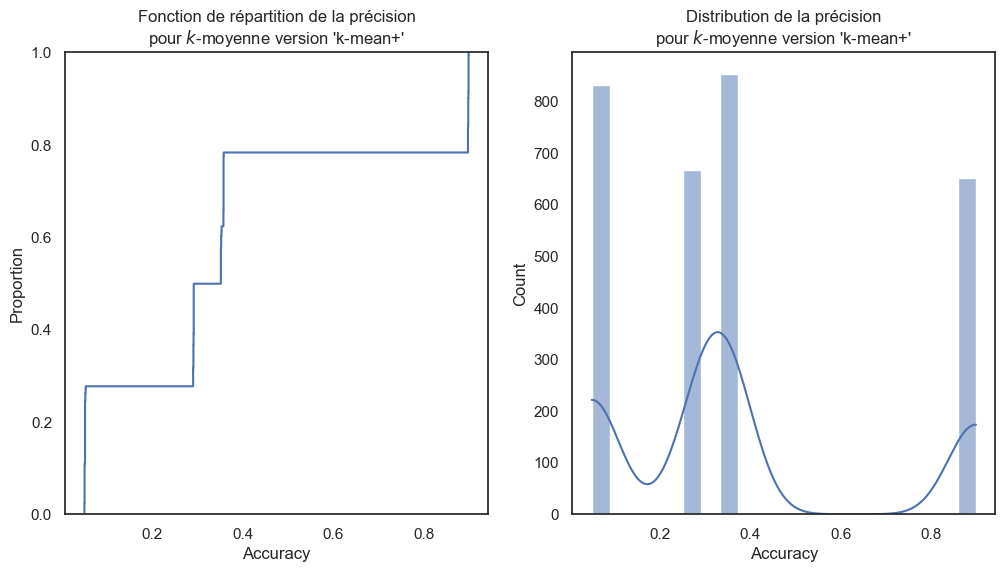

In [127]:
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    k_means = KMeans(n_clusters=n_clusters, n_init=1, init="k-means++", random_state=np.random.randint(0, 100000)).fit(X)
    yhat = k_means.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $k$-moyenne version 'k-mean+'")
ax2.set_title("Distribution de la précision\npour $k$-moyenne version 'k-mean+'")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

L'initialisation "k-means++" ne semble pas beaucoup changer la variance du score de précision dans notre cas.